# United Nations General Assembly Resolutions
## Exploratory Data Analysis

In [1]:
import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

dirname=os.path.dirname

ROOT_DIR = os.path.join('..', '..')
INIT_DATA_PATH = os.path.join(ROOT_DIR, 'data', 'initial')
INTER_DATA_PATH = os.path.join(ROOT_DIR, 'data', 'inter')
FINAL_DATA_PATH = os.path.join(ROOT_DIR, 'data', 'final')
ERROR_LOG = os.path.join(ROOT_DIR, 'error-logs')
OUTPUT_PATH = os.path.join(ROOT_DIR, 'output', 'eda')

plt.style.use("seaborn")
plt.rcParams['figure.dpi'] = 75
plt.rcParams['savefig.dpi'] = 300

### Loading Data

In [2]:
md = pd.read_json(os.path.join(FINAL_DATA_PATH, 'metadata.json'))
md['Vote date'] = pd.to_datetime(md['Vote date'])
votes = pd.read_json(os.path.join(FINAL_DATA_PATH, 'votes.json'))
tokens = pd.read_json(os.path.join(FINAL_DATA_PATH, 'unga_tokens.json'))
corpus = pd.read_json(os.path.join(FINAL_DATA_PATH, 'unga_corpus_clean.json'))

### Data Facts

In [3]:
print("Total number of resolutions:", md.shape[0])
print("Total number resolutions that were adopted with vote:", md[md.Votes].shape[0])
print("First resolution was adopted in:", md['Vote date'].min().date())
print("Latest resolution was adopted in:", md['Vote date'].max().date())
print("Number of unique countries that have been a member:", votes.shape[1])
print("Number of resolutions with text:", tokens.shape[0])
# print("Number of resolutions with text after removing duplicate texts:", corpus.shape[0])


Total number of resolutions: 19428
Total number resolutions that were adopted with vote: 5235
First resolution was adopted in: 1946-01-24
Latest resolution was adopted in: 2022-03-02
Number of unique countries that have been a member: 202
Number of resolutions with text: 17199


Number of voting members in the first session: 51
Number of voting members in the latest session: 193


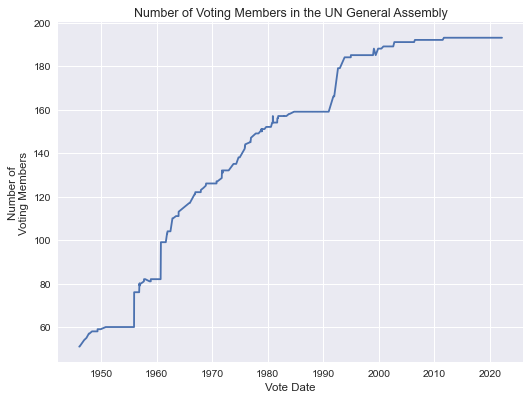

In [4]:
n_countries = (~votes.isna()).sum(axis=1).to_frame(name='Number of\nVoting Members')
n_countries = md[['Resolution', 'Vote date']].merge(n_countries, how='inner', left_on='Resolution', right_index=True)
n_countries = n_countries.sort_values('Vote date')

print("Number of voting members in the first session:", n_countries.iloc[0, -1])
print("Number of voting members in the latest session:", n_countries.iloc[-1, -1])

plt.figure(figsize = (8,6))
member_line = sns.lineplot(x = 'Vote date', y = 'Number of\nVoting Members',data = n_countries)
member_line.set(title='Number of Voting Members in the UN General Assembly', xlabel='Vote Date')
fig = member_line.get_figure()
fig.savefig(os.path.join(OUTPUT_PATH, 'members_X_time.png'))

### Exploratory Analysis

<Figure size 750x750 with 0 Axes>

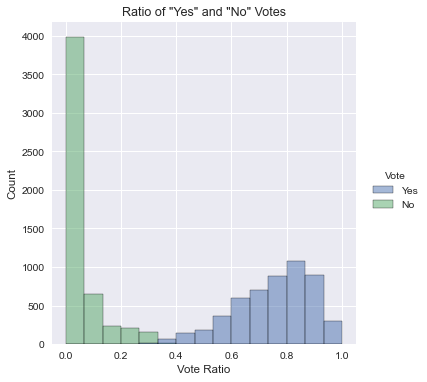

In [5]:
vote_rate = md.loc[md['Votes'], ['Yes', 'No', 'Total']]
vote_rate['Yes'] = vote_rate['Yes'] / vote_rate['Total']
vote_rate['No'] = vote_rate['No'] / vote_rate['Total']
vote_rate.drop(['Total'], axis=1, inplace=True)
vote_rate.reset_index(drop=True, inplace=True)
vote_rate = vote_rate.melt(value_name='Vote Ratio', var_name='Vote')

plt.figure(figsize = (10,10));
vote_dist = sns.displot(vote_rate, x="Vote Ratio", hue="Vote")
vote_dist.set(title='Ratio of "Yes" and "No" Votes')
vote_dist.savefig(os.path.join(OUTPUT_PATH, 'dist_vote.png'))

<Figure size 750x750 with 0 Axes>

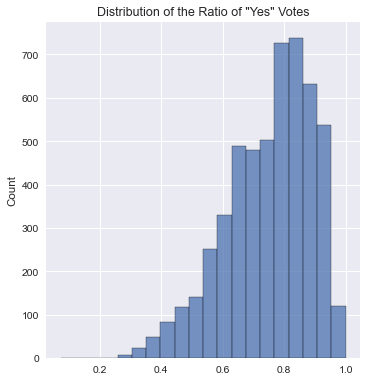

In [6]:
yes_rate = md[md['Votes']]['Yes'] / md[md['Votes']]['Total']
plt.figure(figsize = (10,10));
yes_dist = sns.displot(x=yes_rate, bins=20);
yes_dist.set(title='Distribution of the Ratio of "Yes" Votes');
yes_dist.savefig(os.path.join(OUTPUT_PATH, 'dist_yes.png'));

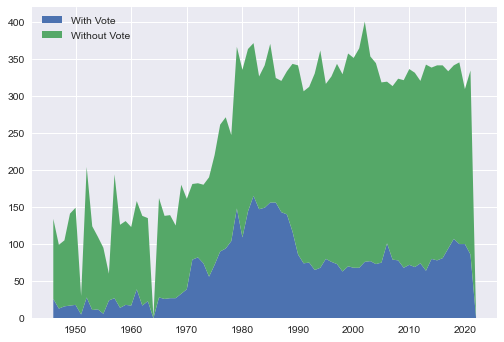

In [7]:
res_year = md.loc[:, ['Resolution', 'Vote date', 'Votes']]
res_year['Year'] = pd.DatetimeIndex(res_year['Vote date']).year.astype(int)

stacked = pd.concat([
    res_year.groupby('Year')[['Votes']].sum(),
    res_year.groupby('Year')[['Resolution']].count()
    ], axis=1)

plt.stackplot(stacked.index,[stacked['Votes'], stacked['Resolution'] - stacked['Votes']], 
    labels=['With Vote', 'Without Vote'])
plt.legend(loc='upper left')
plt.savefig(os.path.join(OUTPUT_PATH, 'res_X_time.png'))

### Exploring the Corpus

Split into three eras: early years of the Cold War (1946-1960, sessions 1-25), transitional period (Sessions 26-45, 1971-1990), Post-Cold-War (Session 46-63; 1991-2020) 

In [8]:
era_names = ['Early Cold War (1946-1960)', 'Transitional Period (1971-1990)', 'Post-Cold War (1991-2022)']

eras = tokens.merge(md[['Resolution', 'Vote date']], on='Resolution', how='inner')
eras['year'] = pd.DatetimeIndex(eras.pop('Vote date')).year.astype(int)

def get_era(year): 
    if year <= 1960:
        return era_names[0]
    if year <= 1990: 
        return era_names[1]
    return era_names[2]

eras['era'] = eras['year'].apply(get_era)

#### Resolution Counts Per Era 

In [9]:
res_year['era'] = res_year['Year'].apply(get_era)
res_year.groupby('era')[['Resolution']].count().sort_values('Resolution')

,Resolution
era,
Early Cold War (1946-1960),1825
Transitional Period (1971-1990),7203
Post-Cold War (1991-2022),10400


#### Available Document Counts Per Era

In [10]:
eras.groupby('era')[['Resolution']].count().sort_values('Resolution')

,Resolution
era,
Early Cold War (1946-1960),1774
Transitional Period (1971-1990),5875
Post-Cold War (1991-2022),9551


<Figure size 750x750 with 0 Axes>

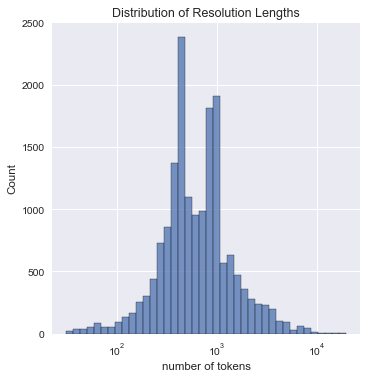

In [11]:
eras['number of tokens'] = eras['tokens'].apply(len)
plt.figure(figsize = (10,10));
length_dist = sns.displot(eras, x='number of tokens', bins=40, log_scale=True);
length_dist.set(title='Distribution of Resolution Lengths');
length_dist.savefig(os.path.join(OUTPUT_PATH, 'dist_length.png'));

<Figure size 750x750 with 0 Axes>

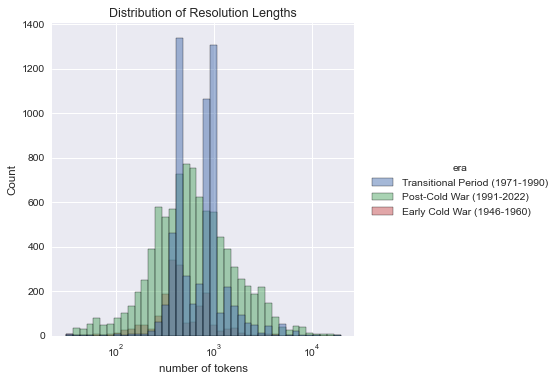

In [12]:
plt.figure(figsize = (10,10));
length_dist = sns.displot(eras, x='number of tokens', bins=40, log_scale=True, hue='era');
length_dist.set(title='Distribution of Resolution Lengths');
length_dist.savefig(os.path.join(OUTPUT_PATH, 'dist_length_eras.png'));

#### Word Clouds Per Era

Early Cold War (1946-1960)


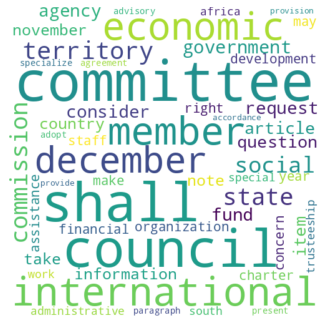

Transitional Period (1971-1990)


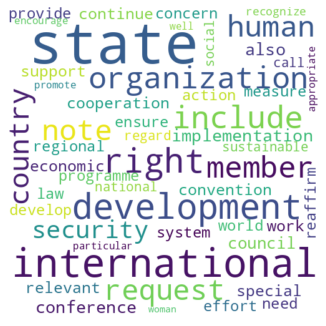

Post-Cold War (1991-2022)


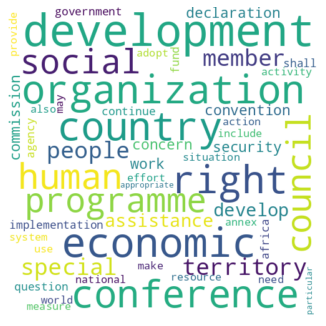

In [14]:
uniques = corpus.drop_duplicates('Text')['Resolution']
eras_u = eras[eras['Resolution'].isin(uniques)]

era_list = [era[1] for era in list(eras_u.groupby('era'))]
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, max_df=.9, max_features=50, lowercase=False)

clouds = []
for era in era_list: 
    vec = vectorizer.fit_transform(era['tokens']).todense().tolist()
    feature_names = vectorizer.get_feature_names_out()
    df = pd.DataFrame(vec, columns=feature_names).T.sum(axis=1)
    cloud = WordCloud(background_color="white", max_words=50, width=500, height=500).generate_from_frequencies(df)
    clouds.append(cloud)

for i, cloud in enumerate(clouds):
    print(era_names[i])
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    cloud.to_file(os.path.join(OUTPUT_PATH, f"word_cloud_{i}.png"))